# BaseLine

In [435]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
from datetime import datetime
import time

# 행 많이보기
pd.set_option('display.max_row', 20)
pd.set_option('display.max_columns', 30)

# 한글 폰트 설정
# fm.get_fontconfig_fonts()
# font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
# font_name = fm.FontProperties(fname=font_location).get_name()
# plt.rc('font', family=font_name)
# plt.rc('font', size=12)
# plt.figure(figsize=(20,10))

# 지수 표현 안보기

# 데이터 로드
data = pd.read_excel('../../Data/2019_data_time.xlsx', encoding='cp949', header=0, parse_dates=["방송일시"])
data_air = pd.read_csv('../../Data/기간별_일평균_대기환경_정보_2019년.csv', encoding='cp949', header=0, parse_dates=["time"])
# 무형 제거

data.drop(data[data['상품군']=='무형'].index, inplace=True)
data.reset_index(inplace=True)



# 판매단가, 취급액 쉼표 제거 , int 변환

# data['판매단가'] = data['판매단가'].str.replace(',','').astype(int)
# data['취급액'] = data['취급액'].str.replace(',','').astype(int)
# data['노출(분)'] = data['노출(분)'].astype(int)



# 취급액 결측치 값 변경
# df.loc[df['취급액']==1]['취급액'] = 50000



# 날짜 변경 ( 다음날 데이터를 현재 날짜로 할 건지 )




# data 의 colname 영어로 변경
# index drop 필요
print(data.columns)
data.columns = ['index', 'time', 'exposure_time', 'mcode', 'product_code', 'product_name', 'category','price','salesAMT']
print(data.columns)
                
# M', 'D', 'day', 'H', 'm',
#3

Index(['index', '방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액'], dtype='object')
Index(['index', 'time', 'exposure_time', 'mcode', 'product_code',
       'product_name', 'category', 'price', 'salesAMT'],
      dtype='object')


# Preprocessing

##  Branch : 12날짜 변경 

In [436]:
# 방송일시를 월,일,시간,요일로 변경하여 저장
data["time"] = pd.to_datetime(data["time"], format='%Y-%m-%d %h:%m', errors='raise')
data["time_month"] = data["time"].dt.month
data["time_day"] = data["time"].dt.day
data["time_hour"] = data["time"].dt.hour
data["time_min"] = data["time"].dt.minute
data["day_of_the_week"] = data["time"].dt.dayofweek
data.head()

index                time  exposure_time   mcode  product_code  \
0      0 2019-01-01 06:00:00           20.0  100346        201072   
1      1 2019-01-01 06:00:00           20.0  100346        201079   
2      2 2019-01-01 06:20:00           20.0  100346        201072   
3      3 2019-01-01 06:20:00           20.0  100346        201079   
4      4 2019-01-01 06:40:00           20.0  100346        201072   

    product_name category  price   salesAMT  time_month  time_day  time_hour  \
0  테이트 남성 셀린니트3종       의류  39900  2099000.0           1         1          6   
1  테이트 여성 셀린니트3종       의류  39900  4371000.0           1         1          6   
2  테이트 남성 셀린니트3종       의류  39900  3262000.0           1         1          6   
3  테이트 여성 셀린니트3종       의류  39900  6955000.0           1         1          6   
4  테이트 남성 셀린니트3종       의류  39900  6672000.0           1         1          6   

   time_min  day_of_the_week  
0         0                1  
1         0                1  
2        20                1  
3        20                1  
4        40                1

In [437]:
# 홈쇼핑 하루 방송 사이클이 오전 06시(06시20분)~익일 02시(02시20분) 까지 이므로 날짜를 맞춰주는 작업 수행
# 0시~3시 사이의 방송시간을 24시~27시로 변경
# 방송 날짜와 요일을 하루전으로 변경
overnight_index_list = data.loc[(data["time_hour"] >=0) & (data["time_hour"] < 3)].index
overnight_index_list
data.loc[overnight_index_list, "time_hour"] += 24
data.loc[overnight_index_list, "time_day"] -= 1
data.loc[overnight_index_list, "day_of_the_week"] -= 1
data.loc[data["day_of_the_week"] == -1, "day_of_the_week"] = 6

In [438]:
# 다음달로 넘어가거나 다음연도로 넘어간 항목은 월,일 재조정
data.loc[(data["time_month"] == 2) & (data["time_day"] == 0), ["time_month", "time_day"]] = 1, 31
data.loc[(data["time_month"] == 3) & (data["time_day"] == 0), ["time_month", "time_day"]] = 2, 28
data.loc[(data["time_month"] == 4) & (data["time_day"] == 0), ["time_month", "time_day"]] = 3, 31
data.loc[(data["time_month"] == 5) & (data["time_day"] == 0), ["time_month", "time_day"]] = 4, 30
data.loc[(data["time_month"] == 6) & (data["time_day"] == 0), ["time_month", "time_day"]] = 5, 31
data.loc[(data["time_month"] == 7) & (data["time_day"] == 0), ["time_month", "time_day"]] = 6, 30
data.loc[(data["time_month"] == 8) & (data["time_day"] == 0), ["time_month", "time_day"]] = 7, 31
data.loc[(data["time_month"] == 9) & (data["time_day"] == 0), ["time_month", "time_day"]] = 8, 31
data.loc[(data["time_month"] == 10) & (data["time_day"] == 0), ["time_month", "time_day"]] = 9, 30
data.loc[(data["time_month"] == 11) & (data["time_day"] == 0), ["time_month", "time_day"]] = 10, 31
data.loc[(data["time_month"] == 12) & (data["time_day"] == 0), ["time_month", "time_day"]] = 11, 30
data.loc[(data["time_month"] == 1) & (data["time_day"] == 0), ["time_month", "time_day"]] = 12, 31

In [439]:
data.tail()

index                time  exposure_time   mcode  product_code  \
37367  38299 2019-12-31 23:40:00           20.0  100448        201391   
37368  38300 2020-01-01 00:00:00           20.0  100448        201383   
37369  38301 2020-01-01 00:00:00           20.0  100448        201390   
37370  38302 2020-01-01 00:00:00           20.0  100448        201384   
37371  38303 2020-01-01 00:00:00           20.0  100448        201391   

         product_name category   price     salesAMT  time_month  time_day  \
37367   일시불쿠첸압력밥솥 6인용       주방  148000   10157000.0          12        31   
37368  무이자쿠첸압력밥솥 10인용       주방  178000   50929000.0          12        31   
37369  일시불쿠첸압력밥솥 10인용       주방  168000  104392000.0          12        31   
37370   무이자쿠첸압력밥솥 6인용       주방  158000   13765000.0          12        31   
37371   일시불쿠첸압력밥솥 6인용       주방  148000   46608000.0          12        31   

       time_hour  time_min  day_of_the_week  
37367         23        40                1  
37368         24         0                1  
37369         24         0                1  
37370         24         0                1  
37371         24         0                1

In [440]:
# 카테고리명 영어로 변경
data.loc[data["category"] == "의류", "category"] = "clothes"
data.loc[data["category"] == "속옷", "category"] = "underwear"
data.loc[data["category"] == "주방", "category"] = "kitchen"
data.loc[data["category"] == "농수축", "category"] = "food"
data.loc[data["category"] == "이미용", "category"] = "beauty"
data.loc[data["category"] == "가전", "category"] = "electronics"
data.loc[data["category"] == "생활용품", "category"] = "necessaries"
data.loc[data["category"] == "건강기능", "category"] = "health"
data.loc[data["category"] == "잡화", "category"] = "goods"
data.loc[data["category"] == "가구", "category"] = "furniture"
data.loc[data["category"] == "침구", "category"] = "bedding"

In [441]:
# 분기 파생변수 생성
data.loc[(data["time_month"] >= 1) & (data["time_month"] < 4), "quater"] = 1
data.loc[(data["time_month"] >= 4) & (data["time_month"] < 7), "quater"] = 2
data.loc[(data["time_month"] >= 7) & (data["time_month"] < 10), "quater"] = 3
data.loc[data["time_month"] >= 10, "quater"] = 4

In [442]:
# 계절 파생변수 생성
# 0 = 봄(3~5월), 1 = 여름(6~8월), 2= 가을(9~11월), 3 = 겨울(12~2월)
data.loc[(data["time_month"] >= 3) & (data["time_month"] < 6), "season"] = 0
data.loc[(data["time_month"] >= 6) & (data["time_month"] < 9), "season"] = 1
data.loc[(data["time_month"] >= 9) & (data["time_month"] < 12), "season"] = 2
data.loc[(data["time_month"] >= 12) | (data["time_month"] < 3), "season"] = 3

In [443]:
# 판매량 계산
data["sales"] = data["salesAMT"] / data["price"]

## 미세먼지 데이터 처리

In [444]:
data_air = data_air.sort_values(by=["time","FP"])

time  FP  UFP   ozon    NO2   CO    SO2
8873 2019-01-01  31   25  0.013  0.033  0.6  0.003
8874 2019-01-01  34   23  0.019  0.024  0.9  0.005
8886 2019-01-01  34   18  0.016  0.028  0.4  0.006
8890 2019-01-01  34   25  0.014  0.034  0.6  0.004
8872 2019-01-01  35   22  0.016  0.033  0.7  0.004
8879 2019-01-01  36   26  0.012  0.032  0.7  0.007
8882 2019-01-01  36   25  0.018  0.026  1.2  0.004
8877 2019-01-01  37   26  0.010  0.036  1.1  0.004
8880 2019-01-01  37   31  0.015  0.033  0.8  0.007
8892 2019-01-01  37   31  0.012  0.028  0.6  0.005
...         ...  ..  ...    ...    ...  ...    ...
0    2019-12-31  26   18  0.023  0.012  0.4  0.002
10   2019-12-31  26   12  0.025  0.016  0.6  0.003
18   2019-12-31  26   14  0.020  0.019  0.3  0.003
1    2019-12-31  27   19  0.021  0.015  0.4  0.003
17   2019-12-31  28   19  0.017  0.017  0.3  0.003
22   2019-12-31  28   13  0.028  0.019  0.2  0.003
24   2019-12-31  28   19  0.020  0.018  0.4  0.003
14   2019-12-31  29   16  0.024  0.015  0.4  0.004
20   2019-12-31  29   17  0.019  0.017  0.4  0.004
12   2019-12-31  32   17  0.023  0.021  0.3  0.002

[8896 rows x 7 columns]

In [452]:
data_air_pivot = data_air.pivot_table(index=["time"], values=["FP", "UFP"], aggfunc=np.mean)
data_air_pivot.loc[data_air_pivot["FP"] < 31, "warning_FP"] = 0
data_air_pivot.loc[data_air_pivot["FP"] < 81, "warning_FP"] = 1
data_air_pivot.loc[data_air_pivot["FP"] < 151, "warning_FP"] = 2
data_air_pivot.loc[data_air_pivot["FP"] >= 151, "warning_FP"] = 3

data_air_pivot.loc[data_air_pivot["UFP"] < 16, "warning_UFP"] = 0
data_air_pivot.loc[data_air_pivot["UFP"] < 36, "warning_UFP"] = 1
data_air_pivot.loc[data_air_pivot["UFP"] < 76, "warning_UFP"] = 2
data_air_pivot.loc[data_air_pivot["UFP"] >= 76, "warning_UFP"] = 3

In [453]:
data_air_pivot

FP    UFP  warning_FP  warning_UFP
time                                             
2019-01-01  39.36  26.12         2.0          2.0
2019-01-02  33.08  21.36         2.0          2.0
2019-01-03  38.80  23.36         2.0          2.0
2019-01-04  59.44  40.36         2.0          2.0
2019-01-05  65.72  42.52         2.0          2.0
2019-01-06  51.08  23.80         2.0          2.0
2019-01-07  54.88  35.76         2.0          2.0
2019-01-08  40.72  19.16         2.0          2.0
2019-01-09  50.20  21.12         2.0          2.0
2019-01-10  57.88  33.16         2.0          2.0
...           ...    ...         ...          ...
2019-12-22  58.16  43.64         2.0          2.0
2019-12-23  49.64  39.36         2.0          2.0
2019-12-24  69.12  52.44         2.0          2.0
2019-12-25  51.44  38.32         2.0          2.0
2019-12-26  48.84  34.24         2.0          2.0
2019-12-27  34.16  23.36         2.0          2.0
2019-12-28  42.04  24.72         2.0          2.0
2019-12-29  45.36  27.48         2.0          2.0
2019-12-30  36.76  25.68         2.0          2.0
2019-12-31  24.44  14.92         2.0          2.0

[356 rows x 4 columns]

## EDA

In [278]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# 한글 폰트 설정
sns.set(font="Malgun Gothic", rc={"axes.unicode_minus":False})
plt.rcParams["figure.figsize"] = (10, 5)

In [434]:
def get_ratio_df(df, total_df):
    new_list = []
    n_col = len(df.columns)
    n_row = len(total_df)

    for i in range(n_col):
        new_list.append(df.iloc[:,i] / total_df.iloc[:,0])

    list_ndarray =  np.array(new_list)
    new_df = pd.DataFrame(list_ndarray.reshape(n_col,n_row).T, columns=list(df.columns))
    return new_df

#### 월별 취급액

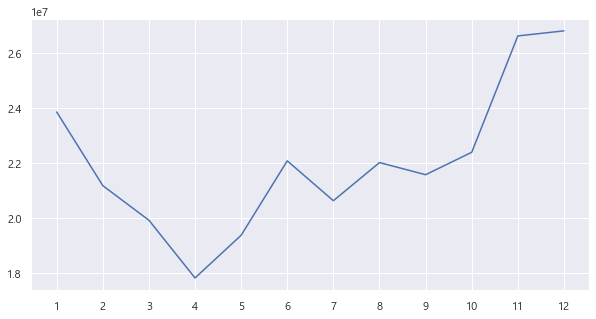

In [280]:
data_monthly_pivot = data.pivot_table(index="time_month", values="salesAMT", aggfunc=[np.mean])
plt.xticks(ticks = range(13), rotation = 0)
plt.plot(data_monthly_pivot)
plt.show()

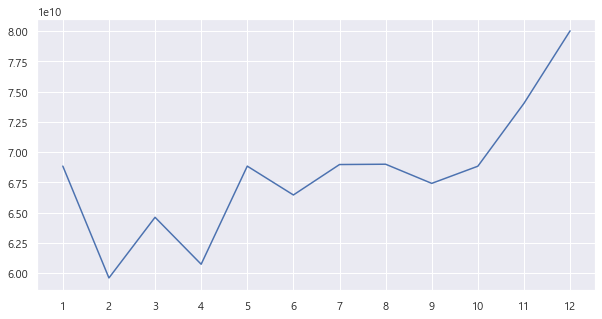

In [281]:
data_monthly_pivot = data.pivot_table(index="time_month", values="salesAMT", aggfunc=np.sum)
plt.xticks(ticks = range(13), rotation = 0)
plt.plot(data_monthly_pivot)
plt.show()

#### 월-제품군 별 총 취급액

In [282]:
data_MonthCate_pivot = data.pivot_table(index=["time_month"],columns="category", values="salesAMT", aggfunc=np.sum)
data_MonthCate_pivot = data_MonthCate_pivot.fillna(0)
data_MonthCate_pivot

category          beauty       bedding       clothes   electronics  \
time_month                                                           
1           3.456610e+09  0.000000e+00  8.508143e+09  7.443582e+09   
2           2.982287e+09  0.000000e+00  6.353548e+09  9.637182e+09   
3           1.935054e+09  0.000000e+00  1.121355e+10  9.185087e+09   
4           2.300892e+09  2.325390e+08  9.552297e+09  1.029206e+10   
5           2.287170e+09  9.268420e+08  1.125595e+10  1.254701e+10   
6           2.262426e+09  2.343745e+09  1.075734e+10  6.147901e+09   
7           3.100676e+09  2.054010e+09  7.997335e+09  7.773842e+09   
8           2.071920e+09  1.385900e+08  7.519910e+09  7.102425e+09   
9           4.824076e+09  1.373200e+08  7.032600e+09  5.534816e+09   
10          5.486537e+09  4.425930e+08  6.520393e+09  5.142377e+09   
11          8.526462e+09  7.161790e+08  8.975461e+09  8.396563e+09   
12          1.008851e+10  0.000000e+00  1.011707e+10  7.923875e+09   

category            food     furniture         goods        health  \
time_month                                                           
1           2.053628e+10  0.000000e+00  1.921087e+09  1.208088e+09   
2           1.201721e+10  2.865252e+09  3.777191e+09  1.136406e+09   
3           7.617622e+09  3.029636e+09  5.304263e+09  1.463361e+09   
4           6.889541e+09  3.149639e+09  3.531384e+09  7.976930e+08   
5           9.772354e+09  2.793887e+09  6.343167e+09  1.106787e+09   
6           9.247418e+09  2.777056e+09  4.185127e+09  2.747047e+09   
7           1.438818e+10  2.411248e+09  6.968579e+09  1.917653e+09   
8           2.101471e+10  2.576131e+09  5.795389e+09  9.936400e+08   
9           1.870237e+10  3.026932e+09  8.716391e+09  1.875243e+09   
10          1.592788e+10  2.947984e+09  6.388970e+09  2.502627e+09   
11          1.487738e+10  1.873053e+09  4.360983e+09  1.864804e+09   
12          1.495129e+10  1.695923e+09  5.002998e+09  2.490471e+09   

category         kitchen   necessaries     underwear  
time_month                                            
1           1.261396e+10  2.561073e+09  1.060010e+10  
2           1.119485e+10  3.123247e+09  6.527907e+09  
3           9.366818e+09  5.324272e+09  1.018290e+10  
4           1.238186e+10  2.575729e+09  9.043216e+09  
5           8.772368e+09  1.936612e+09  1.110494e+10  
6           1.040034e+10  1.681650e+09  1.391574e+10  
7           1.099400e+10  2.279325e+09  9.093623e+09  
8           9.461386e+09  3.919849e+09  8.410758e+09  
9           9.867296e+09  4.164485e+09  3.541833e+09  
10          8.106195e+09  8.714999e+09  6.659845e+09  
11          1.123009e+10  6.482171e+09  6.727834e+09  
12          1.247322e+10  8.883975e+09  6.388235e+09

#### 월-제품군 별 취급액 비율

In [283]:
MonthCate_df = get_ratio_df(data_MonthCate_pivot, data_monthly_pivot)
MonthCate_df.index = MonthCate_df.index+1
MonthCate_df

beauty   bedding   clothes  electronics      food  furniture     goods  \
1   0.050206  0.000000  0.123577     0.108115  0.298280   0.000000  0.027903   
2   0.050026  0.000000  0.106576     0.161657  0.201580   0.048063  0.063360   
3   0.029944  0.000000  0.173524     0.142134  0.117879   0.046882  0.082081   
4   0.037877  0.003828  0.157248     0.169425  0.113414   0.051849  0.058133   
5   0.033221  0.013462  0.163492     0.182245  0.141943   0.040581  0.092134   
6   0.034039  0.035262  0.161848     0.092497  0.139131   0.041782  0.062967   
7   0.044951  0.029778  0.115940     0.112700  0.208589   0.034957  0.101025   
8   0.030026  0.002008  0.108977     0.102927  0.304540   0.037333  0.083985   
9   0.071549  0.002037  0.104305     0.082090  0.277387   0.044894  0.129278   
10  0.079699  0.006429  0.094718     0.074700  0.231374   0.042823  0.092808   
11  0.115174  0.009674  0.121239     0.113420  0.200962   0.025301  0.058908   
12  0.126082  0.000000  0.126439     0.099029  0.186855   0.021195  0.062525   

      health   kitchen  necessaries  underwear  
1   0.017547  0.183212     0.037198   0.153962  
2   0.019062  0.187785     0.052390   0.109501  
3   0.022645  0.144947     0.082390   0.157575  
4   0.013131  0.203827     0.042401   0.148867  
5   0.016076  0.127418     0.028129   0.161299  
6   0.041330  0.156477     0.025301   0.209367  
7   0.027801  0.159383     0.033044   0.131833  
8   0.014400  0.137112     0.056806   0.121887  
9   0.027813  0.146348     0.061766   0.052531  
10  0.036354  0.117753     0.126597   0.096743  
11  0.025190  0.151694     0.087560   0.090879  
12  0.031125  0.155885     0.111028   0.079837

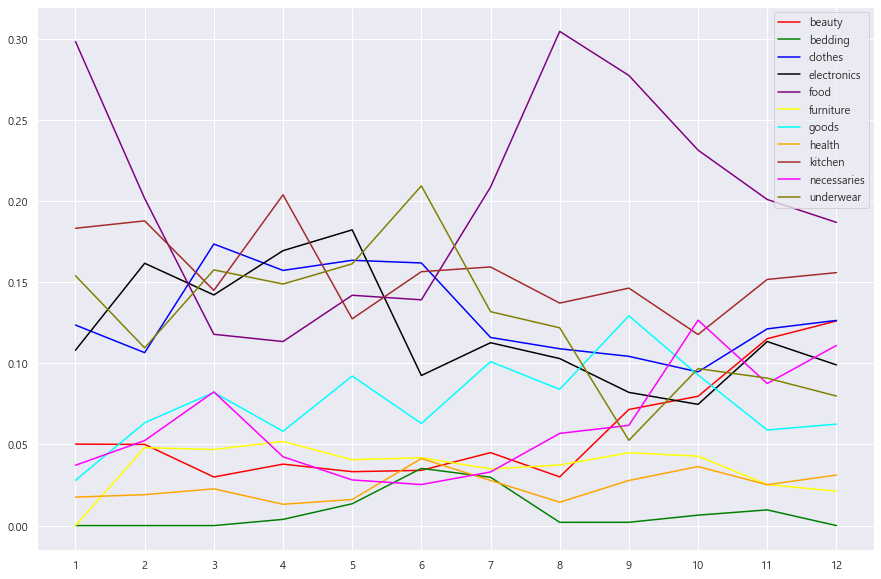

In [284]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.xticks(ticks = range(13), rotation = 0)

plt.plot(MonthCate_df["beauty"], color="red")
plt.plot(MonthCate_df["bedding"], color="green")
plt.plot(MonthCate_df["clothes"], color="blue")
plt.plot(MonthCate_df["electronics"], color="black")
plt.plot(MonthCate_df["food"], color="purple")
plt.plot(MonthCate_df["furniture"], color="yellow")
plt.plot(MonthCate_df["goods"], color="cyan")
plt.plot(MonthCate_df["health"], color="orange")
plt.plot(MonthCate_df["kitchen"], color="brown")
plt.plot(MonthCate_df["necessaries"], color="magenta")
plt.plot(MonthCate_df["underwear"], color="olive")

plt.legend(MonthCate_df.columns, loc="upper right")
plt.show()
plt.rcParams["figure.figsize"] = (10, 5)

#### 분기별 제품군 분석

In [285]:
data_QuaterCate_pivot = data.pivot_table(index=["quater"],columns="category", values="salesAMT", aggfunc=np.sum)
data_QuaterCate_pivot = data_QuaterCate_pivot.fillna(0)
data_QuaterCate_pivot

category        beauty       bedding       clothes   electronics  \
quater                                                             
1.0       8.373951e+09  0.000000e+00  2.607524e+10  2.626585e+10   
2.0       6.850488e+09  3.503126e+09  3.156558e+10  2.898697e+10   
3.0       9.996672e+09  2.329920e+09  2.254984e+10  2.041108e+10   
4.0       2.410151e+10  1.158772e+09  2.561292e+10  2.146282e+10   

category          food     furniture         goods        health  \
quater                                                             
1.0       4.017111e+10  5.894888e+09  1.100254e+10  3.807855e+09   
2.0       2.590931e+10  8.720582e+09  1.405968e+10  4.651527e+09   
3.0       5.410527e+10  8.014311e+09  2.148036e+10  4.786536e+09   
4.0       4.575655e+10  6.516960e+09  1.575295e+10  6.857902e+09   

category       kitchen   necessaries     underwear  
quater                                              
1.0       3.317563e+10  1.100859e+10  2.731091e+10  
2.0       3.155457e+10  6.193991e+09  3.406390e+10  
3.0       3.032268e+10  1.036366e+10  2.104621e+10  
4.0       3.180950e+10  2.408114e+10  1.977591e+10

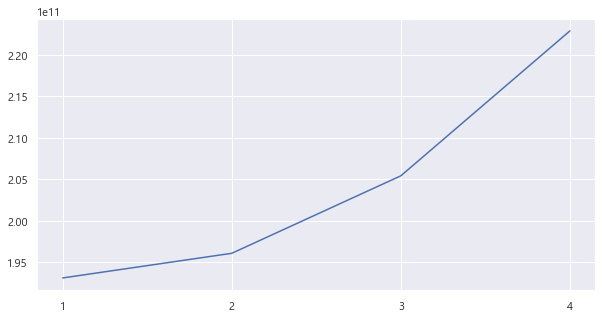

In [286]:
data_quater_pivot = data.pivot_table(index="quater", values="salesAMT", aggfunc=np.sum)
plt.xticks(ticks = range(5), rotation = 0)
plt.plot(data_quater_pivot)
plt.show()

In [287]:
QuaterCate_df = get_ratio_df(data_QuaterCate_pivot, data_quater_pivot)
QuaterCate_df.index = QuaterCate_df.index + 1
QuaterCate_df

beauty   bedding   clothes  electronics      food  furniture     goods  \
1  0.043369  0.000000  0.135044     0.136031  0.208047   0.030530  0.056982   
2  0.034941  0.017868  0.161000     0.147848  0.132150   0.044479  0.071711   
3  0.048668  0.011343  0.109782     0.099369  0.263406   0.039017  0.104575   
4  0.108133  0.005199  0.114914     0.096295  0.205290   0.029239  0.070677   

     health   kitchen  necessaries  underwear  
1  0.019721  0.171817     0.057014   0.141444  
2  0.023725  0.160944     0.031592   0.173742  
3  0.023303  0.147623     0.050454   0.102461  
4  0.030769  0.142716     0.108042   0.088726

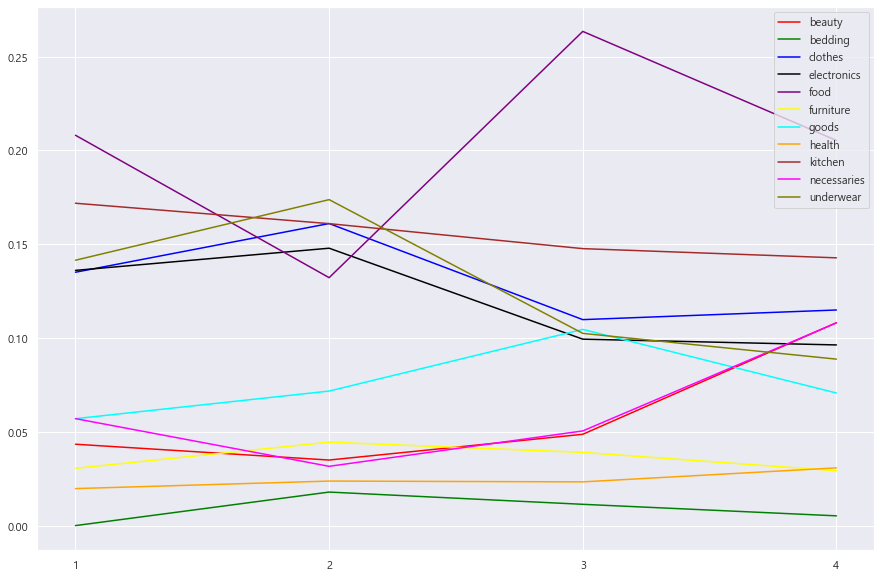

In [288]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.xticks(ticks = range(13), rotation = 0)

plt.plot(QuaterCate_df["beauty"], color="red")
plt.plot(QuaterCate_df["bedding"], color="green")
plt.plot(QuaterCate_df["clothes"], color="blue")
plt.plot(QuaterCate_df["electronics"], color="black")
plt.plot(QuaterCate_df["food"], color="purple")
plt.plot(QuaterCate_df["furniture"], color="yellow")
plt.plot(QuaterCate_df["goods"], color="cyan")
plt.plot(QuaterCate_df["health"], color="orange")
plt.plot(QuaterCate_df["kitchen"], color="brown")
plt.plot(QuaterCate_df["necessaries"], color="magenta")
plt.plot(QuaterCate_df["underwear"], color="olive")

plt.legend(QuaterCate_df.columns, loc="upper right")
plt.show()
plt.rcParams["figure.figsize"] = (10, 5)

#### 제품 가격별 취급액 산포도

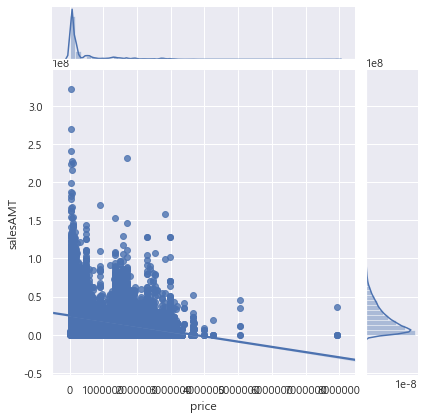

In [289]:
sns.jointplot(data=data, x="price", y="salesAMT", kind = "reg")

#### 일별 분석

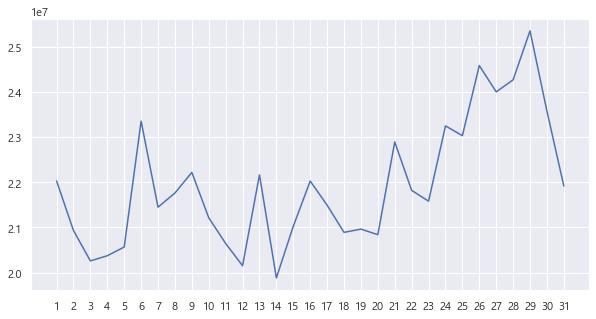

In [290]:
data_dayly_pivot = data.pivot_table(index="time_day", values="salesAMT", aggfunc=np.mean)
plt.xticks(ticks = range(1,32), rotation = 0)
plt.plot(data_dayly_pivot["salesAMT"])
plt.show()

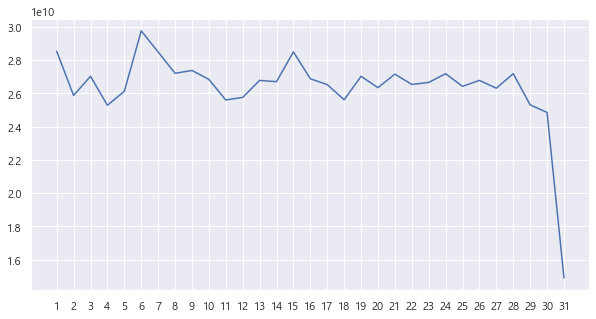

In [291]:
data_dayly_pivot = data.pivot_table(index="time_day", values="salesAMT", aggfunc=np.sum)
plt.xticks(ticks = range(1,32), rotation = 0)
plt.plot(data_dayly_pivot["salesAMT"])
plt.show()

In [292]:
data_DayCate_pivot = data.pivot_table(index=["time_day"],columns="category", values="salesAMT", aggfunc=np.sum)
data_DayCate_pivot = data_DayCate_pivot.fillna(0)
data_DayCate_pivot

category        beauty      bedding       clothes   electronics          food  \
time_day                                                                        
1         1.995438e+09  119836000.0  4.200632e+09  4.229520e+09  4.966373e+09   
2         1.699980e+09  221368000.0  3.293810e+09  2.804742e+09  5.231426e+09   
3         1.625640e+09  442400000.0  2.447748e+09  3.953701e+09  5.556477e+09   
4         2.070494e+09  258071000.0  2.349514e+09  3.263377e+09  5.322248e+09   
5         1.689950e+09  264195000.0  2.884195e+09  3.036587e+09  5.969179e+09   
6         1.495963e+09  181790000.0  4.335216e+09  4.719923e+09  5.266480e+09   
7         1.502924e+09  362471000.0  2.737649e+09  4.169858e+09  5.250470e+09   
8         1.794909e+09  120192000.0  3.354411e+09  3.161481e+09  6.962508e+09   
9         1.196270e+09          0.0  3.121070e+09  3.516899e+09  6.014927e+09   
10        1.679558e+09  231318000.0  3.847456e+09  4.118622e+09  4.797032e+09   
11        1.363921e+09  290649000.0  3.164949e+09  3.644459e+09  5.205861e+09   
12        1.668001e+09  278599000.0  4.116373e+09  3.400455e+09  4.360802e+09   
13        1.509910e+09  230208000.0  3.958009e+09  3.513515e+09  3.884167e+09   
14        1.455890e+09  356549000.0  3.526579e+09  4.035396e+09  5.239611e+09   
15        1.569634e+09  112487000.0  3.732761e+09  4.674959e+09  5.845141e+09   
16        1.062434e+09  228603000.0  5.028158e+09  3.222363e+09  4.903263e+09   
17        1.244321e+09  358407000.0  3.079816e+09  3.624125e+09  4.897897e+09   
18        1.430320e+09  180706000.0  2.985980e+09  2.947403e+09  5.277266e+09   
19        1.469945e+09  260849000.0  3.658907e+09  3.466068e+09  4.926254e+09   
20        2.172619e+09  129428000.0  3.751575e+09  2.976961e+09  4.956581e+09   
21        1.459104e+09  335418000.0  3.998157e+09  2.598068e+09  5.985489e+09   
22        1.025492e+09  205691000.0  3.876663e+09  2.585929e+09  5.547172e+09   
23        2.031674e+09  250842000.0  3.278631e+09  3.197147e+09  4.848241e+09   
24        2.184913e+09  290843000.0  4.092650e+09  2.204381e+09  5.766657e+09   
25        1.954279e+09          0.0  2.999279e+09  2.963754e+09  5.667907e+09   
26        1.689591e+09  135868000.0  3.566423e+09  1.533085e+09  6.868539e+09   
27        1.466394e+09  293643000.0  3.466815e+09  1.100379e+09  6.942109e+09   
28        1.567847e+09  348209000.0  4.145222e+09  1.050711e+09  6.016339e+09   
29        2.062278e+09  175175000.0  2.725773e+09  2.329063e+09  5.865849e+09   
30        1.599893e+09  328003000.0  2.322360e+09  3.115534e+09  4.684247e+09   
31        5.830330e+08          0.0  1.756816e+09  1.968256e+09  2.915729e+09   

category     furniture         goods        health       kitchen  \
time_day                                                           
1         1.978193e+09  1.528633e+09  3.710590e+08  3.585631e+09   
2         1.229159e+09  1.699659e+09  5.106290e+08  3.821060e+09   
3         4.922260e+08  2.734391e+09  1.621850e+08  3.638284e+09   
4         1.013001e+09  1.395730e+09  5.284950e+08  4.419773e+09   
5         1.414877e+09  1.688830e+09  4.519060e+08  3.755305e+09   
6         8.950850e+08  1.578981e+09  4.825500e+08  5.394855e+09   
7         6.971370e+08  2.438976e+09  6.604740e+08  4.720417e+09   
8         1.170828e+09  1.611286e+09  4.476960e+08  3.632669e+09   
9         9.202610e+08  2.104235e+09  3.597080e+08  4.620510e+09   
10        1.476569e+09  1.768262e+09  3.599990e+08  3.587422e+09   
11        9.646520e+08  1.757328e+09  7.918260e+08  3.458421e+09   
12        1.323720e+09  1.598520e+09  3.139910e+08  4.173809e+09   
13        1.166184e+09  2.683603e+09  5.343370e+08  4.525517e+09   
14        7.913800e+08  2.153638e+09  3.327260e+08  4.027556e+09   
15        1.304001e+09  2.053623e+09  1.061283e+09  3.830331e+09   
16        8.262280e+08  1.943365e+09  9.745450e+08  4.037287e+09   
17        1.198314e+09  2.703939e+09  5.838950e+08  4.191921e+09   
18        9.670160e+08  1.870013e+

In [293]:
DayCate_df = get_ratio_df(data_DayCate_pivot, data_dayly_pivot)
DayCate_df.index = DayCate_df.index + 1
DayCate_df

beauty   bedding   clothes  electronics      food  furniture     goods  \
1   0.069946  0.004201  0.147245     0.148258  0.174087   0.069342  0.053583   
2   0.065706  0.008556  0.127310     0.108407  0.202201   0.047509  0.065694   
3   0.060153  0.016370  0.090573     0.146298  0.205605   0.018214  0.101180   
4   0.081893  0.010207  0.092929     0.129075  0.210508   0.040067  0.055205   
5   0.064702  0.010115  0.110426     0.116260  0.228539   0.054171  0.064659   
6   0.050277  0.006110  0.145699     0.158628  0.176997   0.030082  0.053067   
7   0.052764  0.012725  0.096112     0.146393  0.184330   0.024475  0.085626   
8   0.065980  0.004418  0.123306     0.116214  0.255937   0.043039  0.059230   
9   0.043701  0.000000  0.114015     0.128475  0.219729   0.033618  0.076869   
10  0.062585  0.008620  0.143367     0.153472  0.178751   0.055021  0.065891   
11  0.053280  0.011354  0.123636     0.142368  0.203363   0.037683  0.068649   
12  0.064767  0.010818  0.159836     0.132037  0.169327   0.051399  0.062069   
13  0.056391  0.008598  0.147821     0.131220  0.145063   0.043554  0.100225   
14  0.054528  0.013354  0.132082     0.151139  0.196240   0.029640  0.080661   
15  0.055092  0.003948  0.131014     0.164083  0.205155   0.045768  0.072079   
16  0.039534  0.008507  0.187103     0.119908  0.182456   0.030745  0.072315   
17  0.046914  0.013513  0.116116     0.136638  0.184662   0.045179  0.101945   
18  0.055845  0.007055  0.116585     0.115079  0.206046   0.037756  0.073013   
19  0.054399  0.009653  0.135408     0.128271  0.182309   0.038455  0.093477   
20  0.082481  0.004914  0.142425     0.113017  0.188171   0.039638  0.102174   
21  0.053737  0.012353  0.147246     0.095683  0.220436   0.054421  0.090400   
22  0.038647  0.007752  0.146096     0.097453  0.209051   0.034624  0.092635   
23  0.076224  0.009411  0.123008     0.119951  0.181896   0.026046  0.054608   
24  0.080387  0.010701  0.150577     0.081104  0.212167   0.026863  0.103475   
25  0.073970  0.000000  0.113524     0.112179  0.214532   0.006451  0.076421   
26  0.063102  0.005074  0.133197     0.057257  0.256524   0.000000  0.062716   
27  0.055739  0.011162  0.131776     0.041826  0.263874   0.007958  0.070497   
28  0.057677  0.012810  0.152493     0.038653  0.221327   0.022976  0.083025   
29  0.081496  0.006922  0.107715     0.092038  0.231802   0.022991  0.078713   
30  0.064378  0.013198  0.093449     0.125366  0.188489   0.033821  0.059428   
31  0.039122  0.000000  0.117885     0.132073  0.195650   0.066245  0.087639   

      health   kitchen  necessaries  underwear  
1   0.013007  0.125688     0.063188   0.131455  
2   0.019736  0.147689     0.060221   0.146970  
3   0.006001  0.134626     0.077207   0.143772  
4   0.020903  0.174813     0.050274   0.134126  
5   0.017302  0.143778     0.059547   0.130500  
6   0.016218  0.181311     0.062780   0.118832  
7   0.023188  0.165722     0.084962   0.123704  
8   0.016457  0.133535     0.071567   0.110318  
9   0.013140  0.168790     0.074229   0.127434  
10  0.013415  0.133678     0.052696   0.132504  
11  0.030932  0.135100     0.073775   0.119860  
12  0.012192  0.162066     0.040574   0.134914  
13  0.019956  0.169016     0.070374   0.107783  
14  0.012462  0.150845     0.062189   0.116862  
15  0.037249  0.134438     0.046315   0.104859  
16  0.036264  0.150232     0.073180   0.099757  
17  0.022014  0.158045     0.070547   0.104426  
18  0.023066  0.187448     0.059687   0.118419  
19  0.033034  0.142837     0.055341   0.126815  
20  0.030803  0.129548     0.070844   0.095985  
21  0.036183  0.131342     0.058724   0.099476  
22  0.012820  0.179640     0.055356   0.125926  
23  0.069084  0.152147     0.052629   0.134996  
24  0.029822  0.139672     0.047126   0.118106  
25  0.039275  0.181812     0.052872   0.128963  
26  0.026961  0.157024     0.083774   0.154369  
27  0.029402  0.187271     0.045944   0.154551  
28  0.027137  0.189792     0.061352   0.132757  
29  0.031094  0.145029  

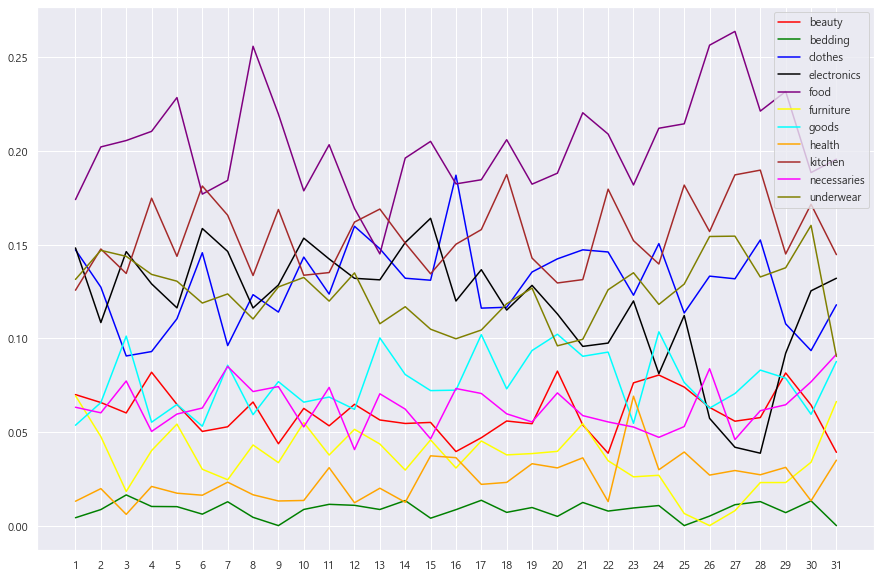

In [294]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.xticks(ticks = range(1,32), rotation = 0)

plt.plot(DayCate_df["beauty"], color="red")
plt.plot(DayCate_df["bedding"], color="green")
plt.plot(DayCate_df["clothes"], color="blue")
plt.plot(DayCate_df["electronics"], color="black")
plt.plot(DayCate_df["food"], color="purple")
plt.plot(DayCate_df["furniture"], color="yellow")
plt.plot(DayCate_df["goods"], color="cyan")
plt.plot(DayCate_df["health"], color="orange")
plt.plot(DayCate_df["kitchen"], color="brown")
plt.plot(DayCate_df["necessaries"], color="magenta")
plt.plot(DayCate_df["underwear"], color="olive")

plt.legend(DayCate_df.columns, loc="upper right")
plt.show()
plt.rcParams["figure.figsize"] = (10, 5)

#### 요일별 분석

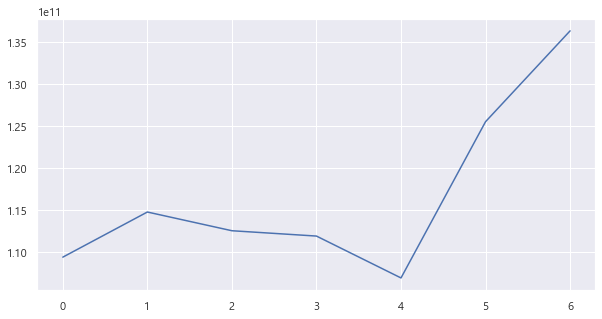

In [295]:
# 요일별 총 취급액
data_DOW_pivot = data.pivot_table(index="day_of_the_week", values="salesAMT", aggfunc=np.sum)
plt.xticks(ticks = range(7), rotation = 0)
plt.plot(data_DOW_pivot["salesAMT"])
plt.show()

In [296]:
data_DOWCate_pivot = data.pivot_table(index=["day_of_the_week"],columns="category", values="salesAMT", aggfunc=np.sum)
data_DOWCate_pivot = data_DOWCate_pivot.fillna(0)
data_DOWCate_pivot

category               beauty       bedding       clothes   electronics  \
day_of_the_week                                                           
0                6.632876e+09  1.207865e+09  1.208269e+10  1.121580e+10   
1                6.542250e+09  1.111133e+09  1.347375e+10  1.119150e+10   
2                7.010408e+09  1.265803e+09  1.186034e+10  1.337186e+10   
3                5.297046e+09  1.025711e+09  1.178658e+10  1.330504e+10   
4                5.321520e+09  8.337000e+08  1.265779e+10  1.290696e+10   
5                7.905968e+09  3.458310e+08  2.154831e+10  1.601187e+10   
6                1.061255e+10  1.201775e+09  2.239413e+10  1.912370e+10   

category                 food     furniture         goods        health  \
day_of_the_week                                                           
0                2.472435e+10  4.288623e+09  7.102266e+09  2.203759e+09   
1                2.543856e+10  4.152825e+09  9.150200e+09  2.879218e+09   
2                2.332168e+10  4.430722e+09  8.011716e+09  2.824034e+09   
3                2.467150e+10  3.773124e+09  8.410938e+09  4.437303e+09   
4                2.248028e+10  4.568805e+09  9.574636e+09  3.331756e+09   
5                2.425589e+10  3.014505e+09  1.092730e+10  2.205522e+09   
6                2.104998e+10  4.918137e+09  9.118470e+09  2.222228e+09   

category              kitchen   necessaries     underwear  
day_of_the_week                                            
0                1.820053e+10  7.454149e+09  1.429248e+10  
1                1.845282e+10  6.575825e+09  1.580821e+10  
2                2.033965e+10  6.663256e+09  1.344980e+10  
3                1.611882e+10  9.245880e+09  1.384263e+10  
4                1.609905e+10  6.838654e+09  1.231723e+10  
5                1.730334e+10  6.833241e+09  1.517432e+10  
6                2.034817e+10  8.036382e+09  1.731226e+10

In [297]:
DOWCate_df = get_ratio_df(data_DOWCate_pivot, data_DOW_pivot)
DOWCate_df

beauty   bedding   clothes  electronics      food  furniture     goods  \
0  0.060627  0.011040  0.110440     0.102516  0.225988   0.039199  0.064917   
1  0.057000  0.009681  0.117391     0.097507  0.221636   0.036182  0.079722   
2  0.062287  0.011247  0.105379     0.118809  0.207213   0.039367  0.071184   
3  0.047331  0.009165  0.105318     0.118886  0.220449   0.033714  0.075155   
4  0.049766  0.007797  0.118374     0.120704  0.210233   0.042727  0.089541   
5  0.062983  0.002755  0.171664     0.127558  0.193234   0.024015  0.087052   
6  0.077840  0.008815  0.164255     0.140267  0.154396   0.036073  0.066881   

     health   kitchen  necessaries  underwear  
0  0.020143  0.166359     0.068133   0.130638  
1  0.025085  0.160772     0.057293   0.137731  
2  0.025092  0.180718     0.059203   0.119501  
3  0.039649  0.144028     0.082616   0.123689  
4  0.031158  0.150556     0.063954   0.115189  
5  0.017570  0.137847     0.054437   0.120886  
6  0.016299  0.149248     0.058945   0.126981

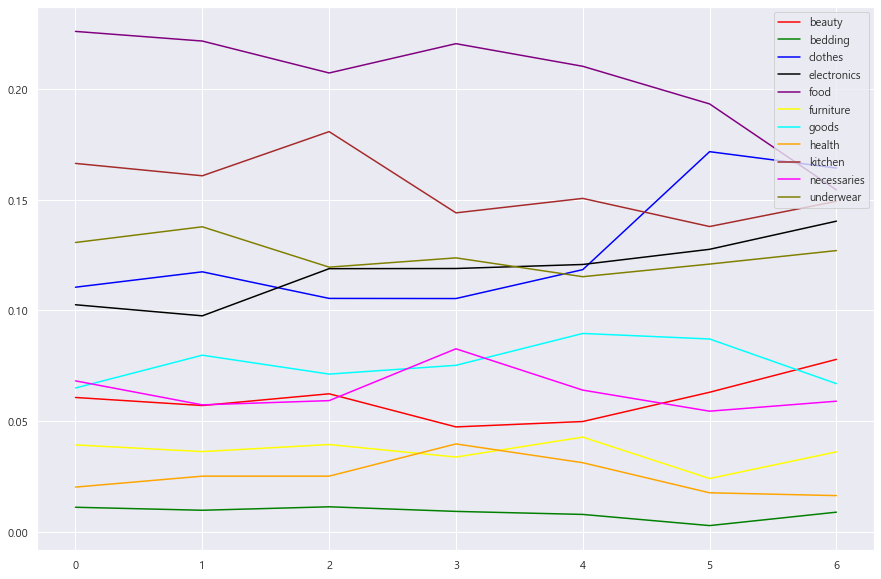

In [298]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.xticks(ticks = range(13), rotation = 0)

plt.plot(DOWCate_df["beauty"], color="red")
plt.plot(DOWCate_df["bedding"], color="green")
plt.plot(DOWCate_df["clothes"], color="blue")
plt.plot(DOWCate_df["electronics"], color="black")
plt.plot(DOWCate_df["food"], color="purple")
plt.plot(DOWCate_df["furniture"], color="yellow")
plt.plot(DOWCate_df["goods"], color="cyan")
plt.plot(DOWCate_df["health"], color="orange")
plt.plot(DOWCate_df["kitchen"], color="brown")
plt.plot(DOWCate_df["necessaries"], color="magenta")
plt.plot(DOWCate_df["underwear"], color="olive")

plt.legend(DOWCate_df.columns, loc="upper right")
plt.show()
plt.rcParams["figure.figsize"] = (10, 5)

### 시간별 분석

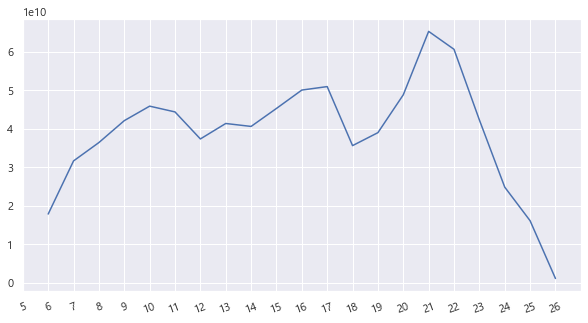

In [299]:
data_grouped_by_broadcast_date_hour = data.pivot_table(index='time_hour', values='salesAMT', aggfunc=np.sum)
plt.xticks(range(0,27), rotation=20)
plt.plot(data_grouped_by_broadcast_date_hour["salesAMT"])
plt.show()

In [300]:
data_HourCate_pivot = data.pivot_table(index=["time_hour"],columns="category", values="salesAMT", aggfunc=np.sum)
data_HourCate_pivot = data_HourCate_pivot.fillna(0)
data_HourCate_pivot

category         beauty       bedding       clothes   electronics  \
time_hour                                                           
6          1.305497e+09  8.390300e+07  5.341795e+09  0.000000e+00   
7          2.276557e+09  0.000000e+00  8.754229e+09  1.982600e+08   
8          2.902313e+09  4.614300e+07  1.058037e+10  2.438790e+08   
9          3.645472e+09  0.000000e+00  1.220332e+10  7.497490e+08   
10         2.023499e+09  1.304350e+08  8.762969e+09  2.772517e+09   
11         1.042427e+09  1.200004e+09  5.931702e+09  1.232250e+09   
12         3.638020e+09  1.627799e+09  4.218496e+09  1.844797e+09   
13         3.716337e+09  1.345702e+09  5.694444e+09  1.199700e+09   
14         3.227549e+09  1.161671e+09  5.884681e+09  1.492956e+09   
15         2.504248e+09  6.474580e+08  4.940648e+09  7.926300e+08   
16         3.329382e+09  0.000000e+00  9.431990e+08  9.102770e+08   
17         1.350700e+09  0.000000e+00  6.705920e+08  5.140880e+08   
18         1.104759e+09  0.000000e+00  5.126550e+08  7.266700e+07   
19         3.622221e+09  0.000000e+00  5.270342e+09  2.618546e+09   
20         3.480752e+09  0.000000e+00  5.752427e+09  1.017495e+10   
21         2.641811e+09  6.837300e+07  3.148251e+09  3.105228e+10   
22         1.436961e+09  1.775940e+08  2.665557e+09  2.921343e+10   
23         2.103373e+09  2.578650e+08  5.220155e+09  1.104218e+10   
24         1.951038e+09  2.227300e+07  6.005822e+09  9.048300e+08   
25         1.788060e+09  2.011050e+08  3.125161e+09  9.672900e+07   
26         2.316430e+08  2.149300e+07  1.767870e+08  0.000000e+00   

category           food     furniture         goods        health  \
time_hour                                                           
6          2.780970e+08  1.613780e+08  1.350567e+09  1.568108e+09   
7          4.603710e+08  9.112100e+07  4.226417e+09  4.690477e+09   
8          1.408970e+08  1.668360e+08  5.838278e+09  1.443522e+09   
9          5.000490e+08  0.000000e+00  6.980311e+09  1.376154e+09   
10         7.548287e+09  1.119910e+08  7.190507e+09  8.250400e+08   
11         1.051583e+10  0.000000e+00  6.561360e+09  6.481520e+08   
12         5.651499e+09  8.796400e+07  3.760009e+09  7.795130e+08   
13         5.224065e+09  0.000000e+00  6.002389e+09  1.335344e+09   
14         5.831344e+09  0.000000e+00  4.764341e+09  1.636480e+09   
15         1.071869e+10  0.000000e+00  3.308502e+09  4.451460e+08   
16         3.296942e+10  0.000000e+00  7.264780e+08  6.547330e+08   
17         3.988054e+10  0.000000e+00  4.951100e+08  3.097720e+08   
18         2.663625e+10  0.000000e+00  5.308290e+08  4.942480e+08   
19         4.480698e+09  5.980180e+08  7.680450e+08  7.377620e+08   
20         4.260394e+09  3.890940e+09  1.438142e+09  1.092706e+09   
21         4.649338e+09  9.399270e+09  4.206080e+08  4.061990e+08   
22         3.199077e+09  7.513378e+09  3.773110e+08  4.507700e+07   
23         9.298770e+08  5.883072e+09  1.627875e+09  6.008390e+08   
24         4.851740e+08  1.082995e+09  3.381993e+09  4.545280e+08   
25         1.484938e+09  1.489530e+08  2.469104e+09  4.951630e+08   
26         9.741200e+07  1.082500e+07  7.735300e+07  6.485700e+07   

category        kitchen   necessaries     underwear  
time_hour                                            
6          2.203386e+09  2.435215e+09  3.090165e+09  
7          3.768648e+09  2.223372e+09  4.946103e+09  
8          6.011654e+09  3.305786e+09  5.731367e+09  
9          8.455213e+09  2.994438e+09  5.197846e+09  
10         9.683774e+09  1.703778e+09  5.120111e+09  
11         9.051953e+09  1.280114e+09  6.906730e+09  
12         1.041891e+10  2.462929e+09  2.855197e+09  
13         9.392384e+09  1.777980e+09  5.675339e+09  
14         7.356692e+09  2.246453e+09  6.998725e+09  
15         1.369967e+10  1.174170e+09  7.048002e+09  
16         8.414203e+09  7.520910e+08  1.356374e+09  
17         6.675498e+09  3.138220e+08  7.477320e+08  
18         4.317236e+09  5.025760e+08  1.437772e+09  
19         6.8

In [301]:
HourCate_df = get_ratio_df(data_HourCate_pivot, data_grouped_by_broadcast_date_hour)
HourCate_df.index = HourCate_df.index + 6
HourCate_df

beauty   bedding   clothes  electronics      food  furniture     goods  \
6   0.073268  0.004709  0.299796     0.000000  0.015608   0.009057  0.075797   
7   0.071962  0.000000  0.276721     0.006267  0.014552   0.002880  0.133597   
8   0.079710  0.001267  0.290581     0.006698  0.003870   0.004582  0.160344   
9   0.086586  0.000000  0.289847     0.017808  0.011877   0.000000  0.165793   
10  0.044111  0.002843  0.191027     0.060439  0.164548   0.002441  0.156748   
11  0.023494  0.027045  0.133686     0.027772  0.237000   0.000000  0.147877   
12  0.097416  0.043588  0.112960     0.049399  0.151332   0.002355  0.100683   
13  0.089845  0.032533  0.137668     0.029004  0.126296   0.000000  0.145113   
14  0.079495  0.028612  0.144940     0.036772  0.143626   0.000000  0.117346   
15  0.055307  0.014299  0.109115     0.017505  0.236725   0.000000  0.073069   
16  0.066513  0.000000  0.018843     0.018185  0.658649   0.000000  0.014513   
17  0.026506  0.000000  0.013160     0.010088  0.782618   0.000000  0.009716   
18  0.031025  0.000000  0.014397     0.002041  0.748020   0.000000  0.014907   
19  0.092921  0.000000  0.135200     0.067174  0.114944   0.015341  0.019703   
20  0.071293  0.000000  0.117822     0.208404  0.087262   0.079695  0.029456   
21  0.040449  0.001047  0.048203     0.475447  0.071187   0.143914  0.006440   
22  0.023691  0.002928  0.043948     0.481647  0.052744   0.123874  0.006221   
23  0.049736  0.006097  0.123435     0.261102  0.021988   0.139110  0.038493   
24  0.078625  0.000898  0.242030     0.036464  0.019552   0.043644  0.136292   
25  0.111212  0.012508  0.194375     0.006016  0.092358   0.009264  0.153570   
26  0.217644  0.020194  0.166103     0.000000  0.091525   0.010171  0.072678   

      health   kitchen  necessaries  underwear  
6   0.088006  0.123660     0.136671   0.173428  
7   0.148266  0.119127     0.070281   0.156346  
8   0.039645  0.165105     0.090791   0.157407  
9   0.032686  0.200824     0.071122   0.123457  
10  0.017985  0.211100     0.037141   0.111615  
11  0.014608  0.204008     0.028851   0.155660  
12  0.020873  0.278990     0.065950   0.076454  
13  0.032283  0.227068     0.042984   0.137206  
14  0.040307  0.181195     0.055330   0.172379  
15  0.009831  0.302560     0.025932   0.155657  
16  0.013080  0.168095     0.015025   0.027097  
17  0.006079  0.131000     0.006158   0.014674  
18  0.013880  0.121240     0.014114   0.040377  
19  0.018926  0.176596     0.122584   0.236612  
20  0.022381  0.120186     0.126555   0.136947  
21  0.006219  0.082736     0.066618   0.057739  
22  0.000743  0.100631     0.059031   0.104541  
23  0.014207  0.047513     0.113602   0.184716  
24  0.018317  0.033357     0.114178   0.276644  
25  0.030798  0.016881     0.111639   0.261378  
26  0.060937  0.042737     0.144152   0.173859

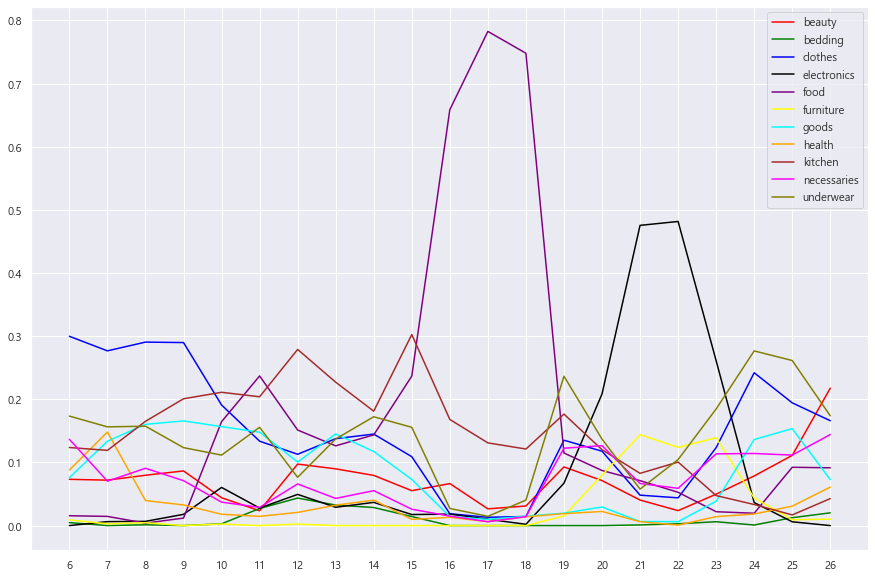

In [302]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.xticks(ticks = range(6,27), rotation = 0)

plt.plot(HourCate_df["beauty"], color="red")
plt.plot(HourCate_df["bedding"], color="green")
plt.plot(HourCate_df["clothes"], color="blue")
plt.plot(HourCate_df["electronics"], color="black")
plt.plot(HourCate_df["food"], color="purple")
plt.plot(HourCate_df["furniture"], color="yellow")
plt.plot(HourCate_df["goods"], color="cyan")
plt.plot(HourCate_df["health"], color="orange")
plt.plot(HourCate_df["kitchen"], color="brown")
plt.plot(HourCate_df["necessaries"], color="magenta")
plt.plot(HourCate_df["underwear"], color="olive")

plt.legend(HourCate_df.columns, loc="upper right")
plt.show()
plt.rcParams["figure.figsize"] = (10, 5)

## 가중치(비율) feature화

#### 월-상품군 취급액 비율 가중치

In [303]:
for i in range(12):
    for cate in data["category"].unique():
        data.loc[(data["category"] == cate) & (data["time_month"] == i+1), "monthCate_weight"] = MonthCate_df.iloc[i][cate]

#### 분기-상품군 취급액 비율 가중치

In [304]:
for i in range(4):
    for cate in data["category"].unique():
        data.loc[(data["category"] == cate) & (data["quater"] == i+1), "quaterCate_weight"] = QuaterCate_df.iloc[i][cate]

#### 일-상품군 취급액 비율 가중치

In [305]:
for i in range(31):
    for cate in data["category"].unique():
        data.loc[(data["category"] == cate) & (data["time_day"] == i+1), "dayCate_weight"] = DayCate_df.iloc[i][cate]

#### 요일-상품군 취급액 비율 가중치

In [306]:
for i in range(7):
    for cate in data["category"].unique():
        data.loc[(data["category"] == cate) & (data["day_of_the_week"] == i), "DOWCate_weight"] = DOWCate_df.iloc[i][cate]

#### 시(hour)-상품군 취급액 비율 가중치

In [307]:
for i in range(6,27):
    for cate in data["category"].unique():
        data.loc[(data["category"] == cate) & (data["time_hour"] == i), "hourCateAmount_weight"] = HourCate_df.iloc[i-6][cate]

## MAPE

In [308]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100

## Training

In [309]:
feature_list = ['exposure_time', 'mcode', 'product_code', 'price', 'time_month', 'time_day',
       'time_hour', 'time_min', 'day_of_the_week',
       'monthCate_weight',
       'DOWCate_weight', 'hourCateAmount_weight',
       'category_bedding', 'category_clothes',
       'category_electronics', 'category_food',
       'category_furniture', 'category_goods',
       'category_health', 'category_kitchen',
       'category_necessaries', 'category_underwear']
label = 'salesAMT'

In [310]:
# 상품군 one-hot encoding
data_dummy = pd.get_dummies(data, columns=['category'], prefix='category', drop_first=True)

In [311]:
train_X = data_dummy[feature_list]
train_y = data_dummy[label]

In [312]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer

# kfold = KFold(n_splits=5, random_state=47, shuffle=True)
# my_scorer = make_scorer(mape, greater_is_better=False)

In [313]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.25, random_state=147, shuffle=True)

In [314]:
rf_model = RandomForestRegressor(n_jobs=-1)
# score = cross_val_score(rf_model, train_X, train_y, scoring=my_scorer, cv=kfold)
# print("교차 검증 점수:\n{}".format(score))

In [315]:
param_dist = {
    "max_depth": [7, 11, 15, 18, 21],
    "max_features": sp_randint(1, len(feature_list)+1),
    "min_samples_split": sp_randint(2, 21),
    "min_samples_leaf": sp_randint(1, 21),
    "bootstrap": [True, False],
    "random_state": [147]
}

n_iter_search = 20
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=n_iter_search)

In [316]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=-1, oob_score=False,
                                                   random_...


In [317]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.653 (std: 0.012)
Parameters: {'bootstrap': False, 'max_depth': 18, 'max_features': 17, 'min_samples_leaf': 5, 'min_samples_split': 19, 'random_state': 147}

Model with rank: 2
Mean validation score: 0.638 (std: 0.011)
Parameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 11, 'min_samples_leaf': 9, 'min_samples_split': 15, 'random_state': 147}

Model with rank: 3
Mean validation score: 0.613 (std: 0.013)
Parameters: {'bootstrap': False, 'max_depth': 21, 'max_features': 16, 'min_samples_leaf': 19, 'min_samples_split': 5, 'random_state': 147}



In [318]:
rf_model2 = RandomForestRegressor(
    n_estimators=300,
    n_jobs=-1,
    bootstrap = False,
    max_depth = 21,
    max_features = 13,
    min_samples_leaf = 4,
    min_samples_split = 4,
    random_state = 147
)

## Use Random Forest model

In [319]:
rf_model2.fit(X_train, y_train)
pred = rf_model2.predict(X_test)

In [320]:
mape(y_test, pred)

563.6379060598463

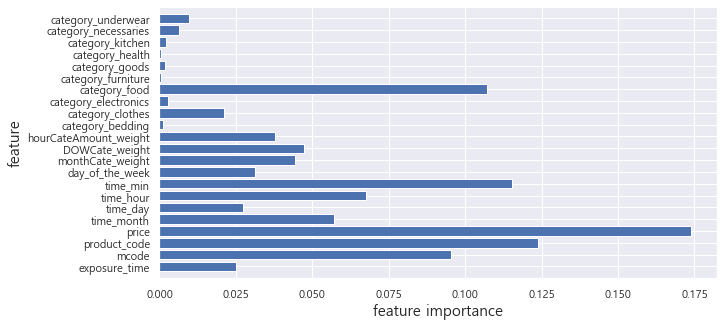

In [321]:
n_feature = X_train.shape[1]
index = np.arange(n_feature)

plt.barh(index, rf_model2.feature_importances_, align='center')
plt.yticks(index, X_train.columns)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)

plt.show()

## Use LGBM

In [325]:
import lightgbm as lgb
model = lgb.LGBMRegressor(
    random_state = 147,
    n_estimators = 3000
    )
model.fit(X_train, y_train)
predicted = model.predict(X_test)

In [326]:
model_score = mape(y_test, predicted)
model_score

504.0549583031828

In [ ]:
n_feature = X_train.shape[1]
index = np.arange(n_feature)

plt.barh(index, model.feature_importances_, align='center')
plt.yticks(index, X_train.columns)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)

plt.show()

In [371]:
import random

iter_num = 100
total_importance = [0] * len(X_train.columns)
total_model_score = 0

for i in range(iter_num):
    random_value = random.randint(1, 10000)
    X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.25, random_state=random_value, shuffle=True)
    model = lgb.LGBMRegressor(
        random_state = random_value,
        n_estimators = 3000
    )
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    model_score = mape(y_test, predicted)
    print(i, model_score)
    total_model_score = total_model_score + model_score
    total_importance = total_importance + model.feature_importances_

0 562.9656968093442
1 546.0497923223011
2 533.7742712135531
3 503.38497126204834
4 531.4888206244261
5 510.85323867586584
6 545.7900628817198
7 539.3036226554983
8 501.2510942381998
9 516.8670964308548
10 540.4675571794625
11 491.1993915843193
12 561.131335929242
13 490.5861522792992
14 524.8580716863253
15 541.4101719130184
16 467.4764001091636
17 567.3248487517211
18 577.7387845484451
19 549.7211488872249
20 482.40970870755115
21 527.9228792742521
22 517.6804137904265
23 496.95559156824345
24 507.8630049719333
25 559.1486104934877
26 497.7748336541974
27 511.15452226202126
28 537.2621499772299
29 499.93661229673154
30 526.18458447042
31 547.9907415131522
32 469.06843668800377
33 495.5480287911677
34 524.5073232803887
35 523.7659220381944
36 491.8176721662884
37 494.4168379778839
38 550.3471331777292
39 556.6482558020385
40 544.3720158756113
41 520.67356031845
42 526.6072621754702
43 582.7169925325891
44 516.3779753054397
45 494.91186644600884
46 512.9566580857222
47 523.0142731080351

In [374]:
total_model_score = total_model_score/iter_num
total_model_score

5.220699048452299

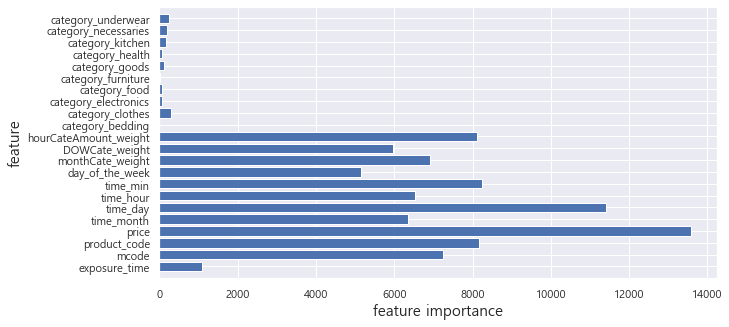

In [375]:
mean_importance = total_importance/iter_num

n_feature = X_train.shape[1]
index = np.arange(n_feature)

plt.barh(index, mean_importance, align='center')
plt.yticks(index, X_train.columns)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)

plt.show()